In [1]:
### PREAMBLE
# Uniform convergence may be unable to explain generalization in deep learning
# Empirical and theoretical evidence demonstrating that uniform convergence based generalization bounds may be meaningless for overparameterized deep networks trained by stochastic gradient descent.
# Vaishnavh Nagarajan
# header.png

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output
import itertools
from IPython.core.display import HTML


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#mpl.rcParams['figure.dpi']= 300 
mpl.rcParams['font.family'] = 'monospace'


def get_random_data(n_points, input_dim=10, inner_radius=1, outer_radius=1.1):
    """ Generates random data from the hypersphere distribution used in the blog"""
    '''
    Inputs: 
    n_points (int): number of points to be sampled
    input_dim (int): dimensionality of hypersphere
    inner_radius (float): radius of inner sphere
    outer_radius (flouat): radius of outer sphere
    
    Output:
    data (n_points x input_dim datapoints  np.array): sampled datapoints
    labels (n_points x 2  np.array): 1-hot encoding of labels
    '''
    data = np.random.normal(size=(n_points,input_dim)) 
    labels = np.zeros(shape=(n_points,2))

    for i in range(n_points):
        if np.random.uniform() > 0.5:
            labels[i,0] = 1
            data[i,:] = inner_radius*(data[i,:]/np.linalg.norm(data[i,:]))
        else:
            labels[i,1] = 1
            data[i,:] = outer_radius*data[i,:]/np.linalg.norm(data[i,:])    

    return data, labels 

# A function to create a TF linear transformation layer
def linear(input_var, input_dim, output_dim, scope=None):
    """ Creates tensorflow graph for linear transformation of a layer"""
    '''
    Inputs: 
    input_var (tf variable): input to the linear transformation
    input_dim (int): dimensionality of input layer
    output_dim (int): dimensionality of output layer
    scope: scope of the variable
    
    Output: linearly transformed layer
    '''
    initializer = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input_var.get_shape()[1], output_dim], initializer=initializer)
        b = tf.get_variable('b',[1,output_dim])
        return tf.matmul(input_var, w)  + b


def get_network(input_var, input_dim, output_dim, width, depth):
    """ Creates the tf graph for the deep ReLU network """
    '''
    Inputs: 
    input_var (tf variable): input to the deep network
    input_dim (int): dimensionality of input layer
    output_dim (int): dimensionality of output layer (number of classes, essentially)
    width (int): number of hidden units per layer
    depth (int >= 2): number of layers in the network
    
    Output: output layer of the deep network
    '''
    
    curr_output = linear(input_var, input_dim, width, scope='0')
    curr_output = tf.nn.relu(curr_output)
    for k in range(depth-2):
        curr_output = tf.nn.relu(linear(curr_output, width, width,scope=str(k+1)))
    curr_output= linear(curr_output, width, output_dim,scope=str(depth-1))     #final layer is just linear
    return curr_output


def reinitialize_weights(weights, placeholder, op):
    """ Executes an op which assigns values to a tf variable from a placeholder """
    '''
    Inputs: 
    weights (a list of np.array): a list of values that will be assigned to a list of tf variables
    placeholder (a list of tf placeholder): a list of placeholders which will carry the weights
    op (tf op): a tensorflow operation that assigns the weights 
                from placeholder llist to some other list of tf variables 
    '''
    
    
    feed_dict = {}
    for k in range(len(placeholder)):
        feed_dict[placeholder[k]] = weights[k]
    return sess.run(op, feed_dict = feed_dict)






def perform_op_over_data(inputs, labels, op, input_ph, label_ph, flags):
    """ Executes an op over all batches in a dataset """
    '''
    Inputs: 
    inputs (np.array): datapoints
    labels (np.array): the labels of the datapoints
    op (tf operation): operation to be executed
    input_ph (tf placeholder): the input placeholder to the deep network
    label_ph (tf placeholder): the label placeholder for the loss function on the deep network
    flags (dict): a dictionary of hyperparameters containing "batch_size" as a key
    
    Output: a list of outputs from the tf run of the ops on each batch in the dataset
    '''
    
    outputs = []
    max_batch_ind = int(inputs.shape[0]/flags["batch_size"])
    for batch_ind in range(max_batch_ind):
        curr_indices = np.array(range(flags["batch_size"]*batch_ind,flags["batch_size"]*(batch_ind+1)))
        outputs += [sess.run(op, 
            feed_dict={input_ph: inputs[curr_indices], 
                label_ph: labels[curr_indices]})]
    return outputs







# Code for changing Matlab aesthetics
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('text', usetex=False)

# A list of colors and markers that we will iterate through
colors = itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00'])
markers = itertools.cycle([ 'h', '*', '<', 'o', 's', 'v', 'D' ])

# The following functions will be of use in transforming the x and y axes in our plots
def log10(x):
    """ Computes log to the base ten for a float """
    return np.log(x)/np.log(10)

def identity(x):
    """ Computes identity function"""
    return x

def plot_figure(xtitle, ytitle, x, y, xticks, ylabels=None, x_transform = log10):
    """ Plots matlab figure """
    '''
    Input:
    xtitle (string): a label for the x axis
    ytitle (string): a label for the y axis
    x (list of floats): a list of x coordinates for which the y coordinate will be plotted
    y (list or a list of lists of floats):  a list of y coordinates or a list of list of y coordinates corresponding
                                  to each line in the plot
    xticks (list of floats): a list of x coordinates which will be marked
    ylabels (a list of strings): label for each line that'll be plotted (None if just a single line)
    x_transform (function): transformation to be applied on the x axis
    
    Output: prints a log-log plot (if y is a list of lists, all the y lists are combined in one plot and
    a legend is added)
    '''
    fig= plt.figure(figsize=(3,3))
    ax = plt.subplot(111)
    ax.set_xlabel(xtitle,fontsize=12)
    ax.set_xticks(log10(x))
    ax.set_xticklabels(xticks)

    ax.set_ylabel("log("+ytitle+")",fontsize=12)
        
    if ylabels is not None:
        for t in range(len(ylabels)):
            color = next(colors)
            marker = next(markers)
            ax.plot(x_transform(x), log10(y[t]), markersize=4, linestyle="-", marker=marker, 
                     color=color,label=ylabels[t],linewidth=1)

        ax.legend(fontsize=10)
    else:
        color = next(colors)
        marker = next(markers)
        ax.plot(x_transform(x), log10(y), markersize=4, 
                 linestyle="-", marker=marker, color=color, linewidth=1)
    
    
    
    plt.show()

    
def plot_slices(n_slices, data, labels, network_op, input_ph2, label_ph2, flags):
    """ Plots 2-dimensional slices of the learned decision boundary in the hypersphere example """
    '''
    Input:
    n_slices (int): number of 2d slices that needs to be printed
    data (np array): a dataset from which pairs of random datapoints will be selected in order to 
    choose the plane of the slice
    labels (np array): labels of the dataset
    network_op (tf graph): output of the neural network
    input_ph2 (tf placeholder): input to neural network
    label_ph2 (tf placeholder): placeholder for neural network
    flags (dict): list of hyperparameters that contains "inner_radius", "outer_radius" and "batch_size" as keys
    '''

    
    scale = 1.2 # how wider than the outer sphere do we want the plots to be?
    x_min, x_max = -scale*flags["outer_radius"],scale*flags["outer_radius"]
    y_min, y_max = -scale*flags["outer_radius"],scale*flags["outer_radius"]
    
    # create a grid of points to evaluate the output at
    grid = 64
    h = (x_max-x_min)/float(grid)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # pick pairs of random indices from the dataset
    random_indices = np.random.choice(range(data.shape[0]), size=2*n_slices, replace = False)
    main_fig, main_ax = plt.subplots(1, n_slices, sharex='col', sharey='row',figsize=(3*n_slices,3))
    
    for t in range(n_slices):
        i = random_indices[2*t]
        j = random_indices[2*t+1]
        
        # this is an array of 2d datapoints
        contour_data_2d = np.c_[xx.ravel(), yy.ravel()]
        
        # x_vec and y_vec correspond to two orthogonal directions
        # the plane spanned by which contains the two chosen datapoints
        x_vec = data[i,:]
        y_vec = data[j,:]
        y_vec = y_vec - np.dot(x_vec,y_vec)*x_vec/np.linalg.norm(x_vec)
        y_vec = y_vec/(np.linalg.norm(y_vec))
        x_vec = x_vec/(np.linalg.norm(x_vec))
        
        # This projects the 2d grid onto the high dimensional space,
        # so that it can be input to the neural network
        contour_data = np.matmul(contour_data_2d,np.vstack([x_vec,y_vec]))

        # pass the grid through the network
        outputs = perform_op_over_data(contour_data, 
                                       np.zeros(shape=(contour_data.shape[0],2)), 
                                       network_op, input_ph2, label_ph2, flags)

        # plot a contour
        ax = main_ax[t]
        Z = np.array([])
        for output in outputs:
            Z = np.concatenate([Z,output[:,0]-output[:,1] > 0])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.get_cmap("Paired"))
        ax.axis('off')
        ax.set_ylim([y_min,y_max])
        ax.set_xlim([x_min,x_max])

        # mark the two datapoints on this contour
        for ind in [i,j]:
            if labels[ind,0]==1:
                marker = 'o'
            else:
                marker = '*'
            ax.scatter(np.dot(data[ind, :],x_vec), np.dot(data[ind, :],y_vec), 
                       c='black', s=30, marker=marker, cmap=plt.cm.Paired)
        # add the cirles
        circle1=plt.Circle((0, 0), 1, color='black',fill=False, linewidth=1)
        circle2=plt.Circle((0, 0), flags["outer_radius"], color='black',fill=False, linewidth=1)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.set(aspect='equal')

    plt.show()



C:\Users\Bozhidar\Anaconda3\envs\ml4ds2part1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Bozhidar\Anaconda3\envs\ml4ds2part1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Bozhidar\Anaconda3\envs\ml4ds2part1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Bozhidar\Anaconda3\envs\ml4ds2part1\l

In [2]:
def get_margin_error(inputs, labels, network_op, input_ph, label_ph, flags, margin=0.0):
    """ Computes margin based error of a network on a given dataset """
    '''
    Inputs: 
    inputs (n_train x input_dim np.array): the dataset on which the error is to be computed
    labels (n_train x n_classes np.array): a 1-hot encoding of the true labels
    network_op (tf operation): the output layer of the network
    input_ph (tf placeholder): input layer of the network
    label_ph (tf placeholder): the tensorflow placeholder for the label s
    flags (dict): hyperparameters, must include an entry with key "batch_size"
    margin (float): a scalar quantity which denotes the hyperparameter in Equation 1. 
                    When this is zero, the output is the 0-1 error
    
    Output (float): fraction of points that have been classified by a margin less than the given margin 
    '''
    
    logits = perform_op_over_data(inputs, labels, network_op, input_ph, label_ph, flags) # Compute the logits on 
    # the dataset over each batch. the perform_op_over_data function is not visible in the blog, but can be found in the notebook
    # after downloading.  The output is a list containing the output from each batch
    logits =  np.vstack(logits) # This creates a single np.array containing all logits
    label_ind = np.argmax(labels, axis=1) # Indices of correct labels
    
    # The following code finds the maximum output of the network after ignoring the true class
    modified_logits = np.copy(logits) 
    for i in range(logits.shape[0]):
        modified_logits[i,label_ind[i]] = -float("inf") 
    max_wrong_logits = np.max(modified_logits,axis=1)
    
    max_true_logits = logits[[i for i in range(logits.shape[0])],list(label_ind)]   # The output of the network on the true class
    error = np.mean((max_true_logits - max_wrong_logits) < float(margin)) 
    return error



In [3]:
# Hyperparams
FLAGS = {
"batch_size": 1, 
"input_dim": 100,
"n_classes" : 2,
"width" : 1000,
"depth" : 2,
"learning_rate" : 0.2,
"threshold" : 0.01, #Proportion of training points can we ignore
"margin" : 4, #margin that needs to be achieved on most training data
"n_test" : 8192,
"inner_radius" : 1.0,
"outer_radius" : 1.2, 
"n_train_list" : [256, 512, 1024, 2048, 4096, 8192, 16384] # the dataset sizes we will experiment with. 
    }

In [4]:

input_placeholder = tf.placeholder(tf.float32, shape=(FLAGS["batch_size"], FLAGS["input_dim"]))
label_placeholder = tf.placeholder(tf.float32, shape=(FLAGS["batch_size"], FLAGS["n_classes"]))

# Create the network
with tf.variable_scope("train"):
    network_output = get_network(input_placeholder, FLAGS["input_dim"], FLAGS["n_classes"], FLAGS["width"], FLAGS["depth"])
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "train")

# This is to save and reinitialize network between each experiment
weights_placeholder = [tf.placeholder(dtype=tf.float32, shape=t.shape) for t in train_vars]
reinitialize_op = [train_vars[t].assign(weights_placeholder[t]) for t in range(len(weights_placeholder))]

# For optimization
cross_entropy_loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder,logits=network_output))
opt = tf.train.GradientDescentOptimizer(FLAGS["learning_rate"])
train_op = opt.minimize(cross_entropy_loss_op, var_list=train_vars)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [6]:
initial_weights = sess.run(train_vars) 

In [7]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_inputs, test_labels = get_random_data(FLAGS["n_test"], FLAGS["input_dim"], FLAGS["inner_radius"], FLAGS["outer_radius"])
# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["n_train_list"])
train_inputs_list = [[] for n_train in FLAGS["n_train_list"]]
train_labels_list =  [[] for n_train in FLAGS["n_train_list"]]
for k in range(FLAGS["n_experiments"]):
    train_inputs_list[k], train_labels_list[k] =  get_random_data(FLAGS["n_train_list"][k], FLAGS["input_dim"], FLAGS["inner_radius"], FLAGS["outer_radius"])

In [8]:
# The following line simply reinitializes the weights to the initialized weights.
# The first time you run this, it is redundant. This is useful when you want to rerun this block of code
reinitialize_weights(initial_weights, weights_placeholder, reinitialize_op)

final_weights_list = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
test_errors_list = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in  range(FLAGS["n_experiments"]):
    print("Experiment no. "+str(k+1)+" running...")
    
    # Train
    epoch=0
    train_margin_error = 1.0
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        perform_op_over_data(train_inputs_list[k], train_labels_list[k], 
                             train_op, input_placeholder, label_placeholder, FLAGS) # Update weights
        # Compute margin-based error for this epoch
        train_margin_error = get_margin_error(train_inputs_list[k], train_labels_list[k], network_output,
                                             input_placeholder, label_placeholder, FLAGS, FLAGS["margin"])  
    # Compute test error
    test_errors_list[k] = get_margin_error(test_inputs, test_labels, network_output,input_placeholder, label_placeholder, FLAGS, 0) 
    final_weights_list[k] = sess.run(train_vars)     # Store weights
    reinitialize_weights(initial_weights, weights_placeholder, reinitialize_op)    # Reinitialize


Experiment no. 1 running...
Experiment no. 2 running...
Experiment no. 3 running...
Experiment no. 4 running...
Experiment no. 5 running...
Experiment no. 6 running...
Experiment no. 7 running...


In [9]:
def get_bounds(initial_weights, final_weights, spectral_norms, margin, n_train):
    """ Computes the bounds from Bartlett et al., 17, Neyshabur et al., 18, and Neyshabur et al., 19, FOR TWO LAYER
        networks after ignoring the bias term since these bounds only apply to networks without biases. 
        Incorporating the bias in these bounds would only make them larger anyway. Note that in the paper, the MNIST experiments 
        were performed on a network without biases. Also note that the first two bounds can be modified to apply to
        deeper networks.
    """
    '''
    Input:
    initial_weights (list of np.array): the initialized weight matrices
    final_weights (list of np.array): the learned weight matrices
    spectral_norms (list of int): spectral norms of learned weight matrices
    margin (float): the gamma value in the generalization bound
    n_train (int): number of training points
    
    Output:
    bound_0: Bartlett et al., 17 bound
    bound_1: Neyshabur et al., 18 bound
    bound_2: Neyshabur et al., 19 bound
    
    '''

    
    bound = spectral_norms[0]*spectral_norms[2]
    bound /= np.sqrt(n_train)
    bound /= margin
    bound *= np.power(np.sum([np.power(np.linalg.norm(np.sum(np.linalg.norm(final_weights[k]
                                                                            -initial_weights[k],axis=0)))
                                       /spectral_norms[k],2.0/3.0)
                                       for k in [0,2]]),1.5) 
    
    bound_0 = bound # Bartlett et al., bound

    bound = spectral_norms[0]*spectral_norms[2]
    bound /= np.sqrt(n_train)
    bound /= margin
    bound *= FLAGS["depth"]*np.sqrt(FLAGS["width"])
    bound *= np.power(np.sum([np.power(np.linalg.norm(final_weights[k]-initial_weights[k])
                                       /spectral_norms[k],2)
                                       for k in [0,2]]),0.5)
    bound_1 = bound # Neyshabur et al., '18 bound
    
    # WARNING: This only holds for 2 layer networks
    bound = 1.0
    bound /= np.sqrt(n_train)
    bound /= margin
    bound *= np.linalg.norm(final_weights[2])
    bound *= (np.linalg.norm(final_weights[0]-initial_weights[0])+np.linalg.norm(initial_weights[0],ord=2))
    bound_2 = bound # Neyshabur et al., '19 bound

    
    return bound_0, bound_1, bound_2


In [10]:
bounds = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    
    spectral_norms = [np.linalg.norm(w,ord=2) for w in final_weights_list[k]]
    bound_0, bound_1, bound_2 = get_bounds(initial_weights, final_weights_list[k], spectral_norms, 
                                           FLAGS["margin"], FLAGS["n_train_list"][k])
    bounds[0] += [bound_0]
    bounds[1] += [bound_1]
    bounds[2] += [bound_2]

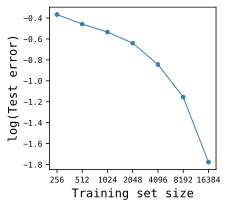

In [11]:
plot_figure("Training set size", "Test error", FLAGS["n_train_list"], 
            test_errors_list, xticks=FLAGS["n_train_list"])

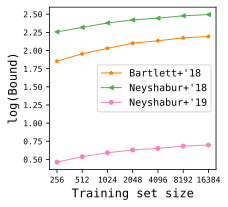

In [12]:
plot_figure("Training set size", "Bound", FLAGS["n_train_list"], bounds, xticks=FLAGS["n_train_list"], 
            ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

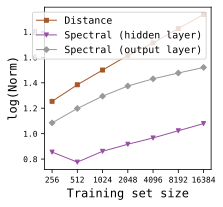

In [13]:
distances = [np.linalg.norm([np.linalg.norm(w[0]-w[1]) for w in zip(final_weights_list[k], initial_weights)]) for k in range(FLAGS["n_experiments"])]
hidden_layer_spectral_norm = [np.linalg.norm(final_weights_list[k][0],ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(final_weights_list[k][2],ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"], [distances, hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            ylabels=["Distance", "Spectral (hidden layer)", "Spectral (output layer)"])

In [15]:
# Compute median margin based bounds 
median_bounds = [[],[],[]]

for k in range(FLAGS["n_experiments"]):
    # Reinitialize weights for every experiment
    reinitialize_weights(final_weights_list[k], weights_placeholder, reinitialize_op) 
    # The code below computes the median margin
    train_outputs = perform_op_over_data(train_inputs_list[k], train_labels_list[k], 
                                         network_output, input_placeholder, label_placeholder, FLAGS) 
    median_margin = np.median(get_margin(train_labels_list[k], np.vstack(train_outputs))) 
    
    spectral_norms = [np.linalg.norm(w,ord=2) for w in final_weights_list[k]]
    bound_0, bound_1, bound_2 = get_bounds(initial_weights, final_weights_list[k], spectral_norms, 
                                           median_margin, FLAGS["n_train_list"][k])
    median_bounds[0] += [bound_0]
    median_bounds[1] += [bound_1]
    median_bounds[2] += [bound_2]

TypeError: get_margin_error() missing 4 required positional arguments: 'network_op', 'input_ph', 'label_ph', and 'flags'

In [14]:
# Hyperparams
FLAGS_2 = {
"batch_size": 64, 
"input_dim": 500,
"n_classes" : 2,
"width" : 10000,
"depth" : 2,
"learning_rate" : 0.5,
"threshold" : 0.01, # Proportion of training points can we ignore
"margin" : 8, # Margin that needs to be achieved on most of the training points
"n_test" : 4096,
"inner_radius" : 1.0,
"outer_radius" : 1.2,
"n_train_list" : [1024,2048,4096,8192] # To experiment with larger dataset sizes,
    # one might have to increase the margin and the width hyperparameters.
}



In [15]:
input_placeholder_2 = tf.placeholder(tf.float32, shape=(FLAGS_2["batch_size"], FLAGS_2["input_dim"]))
label_placeholder_2 = tf.placeholder(tf.float32, shape=(FLAGS_2["batch_size"], FLAGS_2["n_classes"]))

# Create the network
with tf.variable_scope("train_2"):
    network_output_2 = get_network(input_placeholder_2, FLAGS_2["input_dim"], FLAGS_2["n_classes"], FLAGS_2["width"], FLAGS_2["depth"])
train_vars_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "train_2")

# This is to save and reinitialize network
weights_placeholder_2 = [tf.placeholder(dtype=tf.float32, shape=t.shape) for t in train_vars_2]
reinitialize_op_2 = [train_vars_2[t].assign(weights_placeholder_2[t]) for t in range(len(weights_placeholder_2))]

# For optimization
cross_entropy_loss_op_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder_2,
                                                                                 logits=network_output_2))
opt_2 = tf.train.GradientDescentOptimizer(FLAGS_2["learning_rate"])
train_op_2 = opt_2.minimize(cross_entropy_loss_op_2, var_list=train_vars_2)

sess.run(tf.initialize_all_variables())
initial_weights_2 = sess.run(train_vars_2)

In [16]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_inputs_2, test_labels_2 = get_random_data(FLAGS_2["n_test"], FLAGS_2["input_dim"], FLAGS_2["inner_radius"], FLAGS_2["outer_radius"])
FLAGS_2["n_experiments"] = len(FLAGS_2["n_train_list"])
train_inputs_list_2 = [[] for FLAGS_2["n_train"] in FLAGS_2["n_train_list"]]
train_labels_list_2 =  [[] for FLAGS_2["n_train"] in FLAGS_2["n_train_list"]]
for k in range(FLAGS_2["n_experiments"]):
    train_inputs_list_2[k], train_labels_list_2[k] =  get_random_data(FLAGS_2["n_train_list"][k], FLAGS_2["input_dim"], FLAGS_2["inner_radius"], FLAGS_2["outer_radius"])

In [17]:

# We compute S' by projecting the training set
# on to the correspond opposite hyperspheres
projected_train_labels_list_2 =  [[] for n_train in FLAGS_2["n_train_list"]]
projected_train_inputs_list_2 = [[] for n_train in FLAGS_2["n_train_list"]]
for k in range(FLAGS_2["n_experiments"]):
    projected_train_labels_list_2[k] = 1-np.copy(train_labels_list_2[k]) # Flip labels
    projected_train_inputs_list_2[k] = np.copy(train_inputs_list_2[k])
    for i in range(FLAGS_2["n_train_list"][k]):
        if projected_train_labels_list_2[k][i,0] == 1:
            projected_train_inputs_list_2[k][i,:] = projected_train_inputs_list_2[k][i,:]*FLAGS_2["inner_radius"]/FLAGS_2["outer_radius"]
        else:
            projected_train_inputs_list_2[k][i,:] = projected_train_inputs_list_2[k][i,:]*FLAGS_2["outer_radius"]/FLAGS_2["inner_radius"]
            

In [18]:
projected_train_errors_list_2 = [[] for k in range(FLAGS_2["n_experiments"])] # List of training errors on the projected training set across different experiments
final_weights_list_2 = [[] for k in range(FLAGS_2["n_experiments"])] # List of learned weights across the experiments
test_errors_list_2 = [0 for k in range(FLAGS_2["n_experiments"])] # List of test errors across the experiments

reinitialize_weights(initial_weights_2, weights_placeholder_2, reinitialize_op_2) # Reinitialize network every 
# time this block of code is run

for k in  range(FLAGS_2["n_experiments"]):
    print("Experiment no. "+str(k+1)+" running...")
    # Train
    epoch=0
    train_margin_error = 1.0
    while train_margin_error > FLAGS_2["threshold"]:
        epoch += 1
        # Update weights, compute output on training data and then the margin-based training error       
        perform_op_over_data(train_inputs_list_2[k], train_labels_list_2[k], train_op_2, input_placeholder_2, label_placeholder_2, FLAGS_2) 
        
        train_margin_error = get_margin_error(train_inputs_list_2[k], train_labels_list_2[k], network_output_2,
                                             input_placeholder_2, label_placeholder_2, FLAGS_2, FLAGS_2["margin"])  

        # Compute the error on the projected training set and test (just for monitoring)
        projected_train_error = get_margin_error(projected_train_inputs_list_2[k], projected_train_labels_list_2[k], network_output_2,
                                             input_placeholder_2, label_placeholder_2, FLAGS_2, 0.0)  
        test_error = get_margin_error(test_inputs_2, test_labels_2, network_output_2,
                                             input_placeholder_2, label_placeholder_2, FLAGS_2, 0.0)  
        print("Errors | Training: "+str(train_margin_error)+" Projected training: "+str(projected_train_error)+" Test:"+str(test_error))

    
    # Store the errors
    projected_train_errors_list_2[k] = projected_train_error            
    test_errors_list_2[k] = test_error
    final_weights_list_2[k]= sess.run(train_vars_2)  # Store weights
    reinitialize_weights(initial_weights_2, weights_placeholder_2, reinitialize_op_2)     # Reinitialize for next experiment

Experiment no. 1 running...
Errors | Training: 1.0 Projected training: 0.525390625 Test:0.497802734375
Errors | Training: 1.0 Projected training: 0.5263671875 Test:0.498046875
Errors | Training: 1.0 Projected training: 0.5322265625 Test:0.494873046875
Errors | Training: 1.0 Projected training: 0.5546875 Test:0.4677734375
Errors | Training: 1.0 Projected training: 0.5888671875 Test:0.41015625
Errors | Training: 1.0 Projected training: 0.607421875 Test:0.35009765625
Errors | Training: 1.0 Projected training: 0.61328125 Test:0.31884765625
Errors | Training: 1.0 Projected training: 0.6103515625 Test:0.307373046875
Errors | Training: 1.0 Projected training: 0.6162109375 Test:0.30810546875
Errors | Training: 1.0 Projected training: 0.6123046875 Test:0.31982421875
Errors | Training: 1.0 Projected training: 0.5986328125 Test:0.3330078125
Errors | Training: 1.0 Projected training: 0.6025390625 Test:0.346435546875
Errors | Training: 1.0 Projected training: 0.6044921875 Test:0.362060546875
Errors

Errors | Training: 0.71875 Projected training: 1.0 Test:0.42333984375
Errors | Training: 0.7119140625 Projected training: 1.0 Test:0.4228515625
Errors | Training: 0.705078125 Projected training: 1.0 Test:0.4228515625
Errors | Training: 0.7021484375 Projected training: 1.0 Test:0.422119140625
Errors | Training: 0.6962890625 Projected training: 1.0 Test:0.42138671875
Errors | Training: 0.689453125 Projected training: 1.0 Test:0.421630859375
Errors | Training: 0.6826171875 Projected training: 1.0 Test:0.421142578125
Errors | Training: 0.6787109375 Projected training: 1.0 Test:0.42138671875
Errors | Training: 0.671875 Projected training: 1.0 Test:0.42138671875
Errors | Training: 0.66796875 Projected training: 1.0 Test:0.42138671875
Errors | Training: 0.6630859375 Projected training: 1.0 Test:0.421142578125
Errors | Training: 0.65625 Projected training: 1.0 Test:0.4208984375
Errors | Training: 0.6513671875 Projected training: 1.0 Test:0.421142578125
Errors | Training: 0.6416015625 Projected

Errors | Training: 0.111328125 Projected training: 1.0 Test:0.42431640625
Errors | Training: 0.109375 Projected training: 1.0 Test:0.42431640625
Errors | Training: 0.1064453125 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.1044921875 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.1025390625 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.1015625 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.0986328125 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.09765625 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.0927734375 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.091796875 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.087890625 Projected training: 1.0 Test:0.425048828125
Errors | Training: 0.0859375 Projected training: 1.0 Test:0.42529296875
Errors | Training: 0.0859375 Projected training: 1.0 Test:0.425537109375
Errors | Training: 0.083984375 Pr

Errors | Training: 1.0 Projected training: 0.6923828125 Test:0.38037109375
Errors | Training: 1.0 Projected training: 0.70068359375 Test:0.381103515625
Errors | Training: 1.0 Projected training: 0.70947265625 Test:0.382080078125
Errors | Training: 1.0 Projected training: 0.716796875 Test:0.3828125
Errors | Training: 1.0 Projected training: 0.7236328125 Test:0.384033203125
Errors | Training: 1.0 Projected training: 0.73046875 Test:0.384765625
Errors | Training: 1.0 Projected training: 0.73876953125 Test:0.382568359375
Errors | Training: 1.0 Projected training: 0.7470703125 Test:0.382080078125
Errors | Training: 1.0 Projected training: 0.7578125 Test:0.380126953125
Errors | Training: 1.0 Projected training: 0.767578125 Test:0.378173828125
Errors | Training: 1.0 Projected training: 0.7783203125 Test:0.378173828125
Errors | Training: 0.99755859375 Projected training: 0.796875 Test:0.38134765625
Errors | Training: 0.99755859375 Projected training: 0.80224609375 Test:0.377685546875
Errors | 

Errors | Training: 0.306640625 Projected training: 1.0 Test:0.345703125
Errors | Training: 0.296875 Projected training: 1.0 Test:0.345703125
Errors | Training: 0.28857421875 Projected training: 1.0 Test:0.345458984375
Errors | Training: 0.2802734375 Projected training: 1.0 Test:0.345458984375
Errors | Training: 0.27197265625 Projected training: 1.0 Test:0.345947265625
Errors | Training: 0.2666015625 Projected training: 1.0 Test:0.34619140625
Errors | Training: 0.25830078125 Projected training: 1.0 Test:0.346435546875
Errors | Training: 0.25341796875 Projected training: 1.0 Test:0.346435546875
Errors | Training: 0.24560546875 Projected training: 1.0 Test:0.34619140625
Errors | Training: 0.23828125 Projected training: 1.0 Test:0.34619140625
Errors | Training: 0.23095703125 Projected training: 1.0 Test:0.345947265625
Errors | Training: 0.2236328125 Projected training: 1.0 Test:0.345703125
Errors | Training: 0.21533203125 Projected training: 1.0 Test:0.345947265625
Errors | Training: 0.206

Errors | Training: 1.0 Projected training: 0.4326171875 Test:0.25732421875
Errors | Training: 1.0 Projected training: 0.47265625 Test:0.274658203125
Errors | Training: 1.0 Projected training: 0.505615234375 Test:0.288818359375
Errors | Training: 1.0 Projected training: 0.531494140625 Test:0.305908203125
Errors | Training: 1.0 Projected training: 0.5478515625 Test:0.319091796875
Errors | Training: 1.0 Projected training: 0.56396484375 Test:0.3251953125
Errors | Training: 1.0 Projected training: 0.580322265625 Test:0.328857421875
Errors | Training: 1.0 Projected training: 0.59228515625 Test:0.33056640625
Errors | Training: 1.0 Projected training: 0.611572265625 Test:0.331298828125
Errors | Training: 1.0 Projected training: 0.61962890625 Test:0.3291015625
Errors | Training: 1.0 Projected training: 0.63232421875 Test:0.32666015625
Errors | Training: 0.999755859375 Projected training: 0.64404296875 Test:0.328369140625
Errors | Training: 0.999267578125 Projected training: 0.65576171875 Test:

Errors | Training: 0.11865234375 Projected training: 0.999755859375 Test:0.257568359375
Errors | Training: 0.11279296875 Projected training: 1.0 Test:0.257568359375
Errors | Training: 0.1083984375 Projected training: 1.0 Test:0.257568359375
Errors | Training: 0.10302734375 Projected training: 1.0 Test:0.257568359375
Errors | Training: 0.0966796875 Projected training: 1.0 Test:0.257568359375
Errors | Training: 0.091552734375 Projected training: 1.0 Test:0.257568359375
Errors | Training: 0.085205078125 Projected training: 1.0 Test:0.2578125
Errors | Training: 0.079833984375 Projected training: 1.0 Test:0.2578125
Errors | Training: 0.07568359375 Projected training: 1.0 Test:0.258056640625
Errors | Training: 0.072265625 Projected training: 1.0 Test:0.258544921875
Errors | Training: 0.067626953125 Projected training: 1.0 Test:0.258544921875
Errors | Training: 0.064453125 Projected training: 1.0 Test:0.258544921875
Errors | Training: 0.061279296875 Projected training: 1.0 Test:0.258056640625

Errors | Training: 0.0989990234375 Projected training: 0.9769287109375 Test:0.135986328125
Errors | Training: 0.0853271484375 Projected training: 0.9783935546875 Test:0.135009765625
Errors | Training: 0.075439453125 Projected training: 0.979736328125 Test:0.134765625
Errors | Training: 0.066650390625 Projected training: 0.9810791015625 Test:0.134765625
Errors | Training: 0.05810546875 Projected training: 0.9833984375 Test:0.134033203125
Errors | Training: 0.051513671875 Projected training: 0.984619140625 Test:0.13427734375
Errors | Training: 0.044921875 Projected training: 0.9852294921875 Test:0.134033203125
Errors | Training: 0.0394287109375 Projected training: 0.9862060546875 Test:0.133544921875
Errors | Training: 0.0340576171875 Projected training: 0.9873046875 Test:0.13330078125
Errors | Training: 0.0291748046875 Projected training: 0.988037109375 Test:0.132568359375
Errors | Training: 0.026123046875 Projected training: 0.9892578125 Test:0.132568359375
Errors | Training: 0.02294921

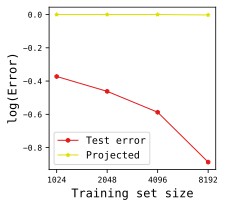

In [19]:
plot_figure("Training set size", "Error", FLAGS_2["n_train_list"], 
            [test_errors_list_2, projected_train_errors_list_2],
            xticks=FLAGS_2["n_train_list"], ylabels=["Test error", "Projected "])

Code by Nagarajan et al. [1].

[1] Nagarajan, V., & Kolter, J. Z. (2019). Uniform convergence may be unable to explain generalization in deep learning. In Advances in Neural Information Processing Systems (pp. 11615-11626).